최근 출간된 책 Hands-On Large Language Models
(Jay Alammar, Maarten Grootendorst 저, 2024)을 읽고 그 내용을 정리해보려고 합니다. 이 책은 급속도로 발전하고 있는 대규모 언어 모델(Large Language Models, LLMs)의 이론을 쉽게 풀어내며 동시에 실습을 통해 독자들이 직접 경험할 수 있도록 구성했습니다. LLM의 전반적인 내용을 다루고 있어 AI와 자연어 처리에 관심 있는 분들에게 훌륭한 가이드가 될 것 같습니다. 이번 포스팅에서는 이 책의 내용 중 쓸만한 코드와 짧은 설명을 공유하려고 합니다.

# 대규모 언어 모델의 이해

## Tokens and Embedding

토크나이저는 어떻게 텍스트를 자르는가? 3가지 중요 팩터:
1. 어휘 크기 (Vocabulary size)
2. 미등록 단어 (Out-of-vocabulary words) 처리
3. 언어의 특성 (Language characteristics)

토크나이저 분류

1. Word token: 공백이나 구두점을 기준으로 단어 단위로 분리
2. Subword token: 자주 사용되는 단어는 그대로 두고, 드문 단어는 더 작은 단위로 분리 (예: WordPiece, BPE)
3. Character token: 개별 문자 단위로 분리
4. Byte token: 바이트 단위로 분리, 모든 언어와 특수 문자 처리 가능

## Inside of LLM

LLM은 3개의 컴포넌트로 구성:

- Tokenizer: 입력 텍스트를 토큰으로 변환
- Transformer: 토큰을 처리하고 문맥을 이해하는 핵심 아키텍처
- LM head: Transformer의 출력을 받아 다음 토큰을 예측하는 층

### 최근 트랜스포머 블록의 발전

#### RoPE

RoPE는 다음과 같은 특징을 가집니다:

- 상대적 위치 정보 인코딩: RoPE는 토큰 간의 상대적 위치 관계를 직접적으로 모델링합니다.
- 회전 행렬 사용: 위치 정보를 회전 행렬을 통해 인코딩하여 효율적으로 처리합니다.
- 길이 외삽(extrapolation) 능력: 학습 시 사용된 시퀀스 길이보다 긴 시퀀스에 대해서도 잘 작동합니다.
- 계산 효율성: 기존 위치 임베딩 방식에 비해 계산 효율성이 높습니다.
- 성능 향상: 특히 장문 텍스트 처리에서 성능 향상을 보입니다.

RoPE는 GPT-3, PaLM, LLaMA 등 최신 대규모 언어 모델에서 널리 사용되고 있으며, 특히 긴 문맥을 다루는 데 효과적입니다.

In [2]:
# | echo: false
import warnings

from transformers import logging

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시


# 사전 학습된 LLM 사용

## 텍스트 분류

자연어 처리에서 흔히 수행되는 작업 중 하나가 분류입니다. 이 작업의 목표는 입력된 텍스트에 레이블이나 클래스를 할당하도록 모델을 훈련시키는 것입니다. 텍스트 분류는 전 세계적으로 다양한 용도로 활용되고 있습니다. 감성 분석, 의도 파악, 개체 추출, 언어 감지 등이 그 예입니다.

대표적 언어 모델과 생성형 언어 모델이 분류 작업에 미치는 영향은 실로 막대합니다. 이러한 모델들은 텍스트 분류의 정확도와 효율성을 크게 향상시켰으며 더 복잡하고 미묘한 분류 작업을 가능하게 만들었습니다. 특히 사전 학습된 대규모 언어 모델(LLM)의 등장으로 텍스트 분류 작업의 성능이 비약적으로 발전했습니다.

### 텍스트 감정 분석 with Representation model

텍스트 데이터를 가져와 텍스트의 감정 분석을 "cardiffnlp/twitter-roberta-base-sentiment-latest" 모델을 사용해 진행합니다. 이 모델은 RoBERTa 아키텍처를 기반으로 하며, 특히 트위터 데이터로 미세 조정되어 소셜 미디어 텍스트의 감정 분석에 최적화되어 있습니다.

In [12]:
import numpy as np
from datasets import load_dataset
from sklearn.metrics import classification_report
from tqdm import tqdm
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

# 데이터셋 불러오기
data = load_dataset("rotten_tomatoes")

# Hugging Face 모델
model_name: str = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# 모델을 파이프라인에 로드
pipe = pipeline(model=model_name, tokenizer=model_name, top_k=None, device="cuda:0")

# 추론 실행
y_pred: list[int] = []
for output in tqdm(pipe(KeyDataset(data["test"], "text")), total=len(data["test"])):
    negative_score = output[0]["score"]
    positive_score = output[2]["score"]
    assignment = np.argmax([negative_score, positive_score])
    y_pred.append(assignment)


def evaluate_performance(y_true: list[int], y_pred: list[int]) -> None:
    """분류 보고서 생성 및 출력"""
    performance: str = classification_report(
        y_true, y_pred, target_names=["부정적", "긍정적"]
    )
    print(performance)


# 성능 평가 실행
evaluate_performance(data["test"]["label"], y_pred)


100%|█████████████████████████| 1066/1066 [00:02<00:00, 459.29it/s]

              precision    recall  f1-score   support

         부정적       0.50      1.00      0.67       533
         긍정적       0.00      0.00      0.00       533

    accuracy                           0.50      1066
   macro avg       0.25      0.50      0.33      1066
weighted avg       0.25      0.50      0.33      1066



In [13]:
# | echo: false
import gc

import torch

gc.collect()
torch.cuda.empty_cache()


### 텍스트 감정 분석 with Generative model

생성형 모델을 사용한 텍스트 감정 분석은 기존의 분류 기반 접근 방식과는 다른 새로운 패러다임을 제시합니다. 이 방식은 기존 방법보다 더 정확하고 세밀한 결과를 제공할 수 있지만, 모델의 훈련과 계산 비용이 높다는 단점도 있습니다. 

In [14]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

# 영화 리뷰 데이터셋 로드
data = load_dataset("rotten_tomatoes")

# Hugging Face 모델
model_name: str = "google/flan-t5-small"

# 모델을 파이프라인에 로드
pipe = pipeline("text2text-generation", model=model_name, device="cuda:0")

# 데이터 준비
prompt = "Is the following sentence positive or negative? "
data = data.map(lambda example: {"t5": prompt + example["text"]})

# 추론 실행
y_pred = []
for output in tqdm(pipe(KeyDataset(data["test"], "t5")), total=len(data["test"])):
    text = output[0]["generated_text"]
    y_pred.append(0 if text == "negative" else 1)


def evaluate_performance(y_true: list[int], y_pred: list[int]) -> None:
    """분류 보고서 생성 및 출력"""
    performance: str = classification_report(
        y_true, y_pred, target_names=["부정적", "긍정적"]
    )
    print(performance)


# 성능 평가 실행
evaluate_performance(data["test"]["label"], y_pred)


100%|█████████████████████████| 1066/1066 [00:08<00:00, 121.39it/s]

              precision    recall  f1-score   support

         부정적       0.83      0.85      0.84       533
         긍정적       0.85      0.83      0.84       533

    accuracy                           0.84      1066
   macro avg       0.84      0.84      0.84      1066
weighted avg       0.84      0.84      0.84      1066



In [15]:
# | echo: false
import gc

import torch

gc.collect()
torch.cuda.empty_cache()


## 텍스트 클러스터링과 토픽 클러스터링

텍스트 클러스터링과 토픽 모델링은 문서 컬렉션을 분석하는 두 가지 주요 접근 방식입니다. 텍스트 클러스터링은 유사한 문서들을 그룹화하여 컬렉션을 여러 클러스터로 나누는 것을 목표로 합니다. 일반적으로 각 문서는 하나의 클러스터에만 속하게 됩니다. 반면 토픽 모델링은 문서 컬렉션에 내재된 추상적인 '토픽'들을 발견하는 것을 목표로 합니다.

### BERTopic: 모듈식 토픽 모델링 프레임워크

BERTopic은 최신 자연어 처리 기술을 활용한 강력한 토픽 모델링 프레임워크입니다. BERTopic은 전통적인 토픽 모델링 기법인 LDA에 비해 더 정교한 결과를 제공할 수 있으며, 특히 짧은 텍스트나 특정 도메인의 텍스트에 대해 우수한 성능을 보입니다. 학술 연구, 소셜 미디어 분석, 고객 피드백 분석 등 다양한 분야에서 활용될 수 있으며, 대규모 문서 컬렉션에서 의미 있는 인사이트를 추출하는 데 유용합니다.

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

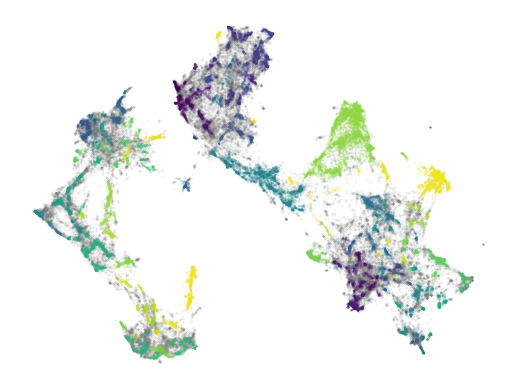

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import umap
from datasets import load_dataset
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

# huggingface에서 데이터 로드
dataset = load_dataset("effectiveML/ArXiv-10")["train"]

# 메타데이터 추출
abstracts = dataset["abstract"]
titles = dataset["title"]

# 1단계
# 각 초록에 대한 임베딩 생성
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

# 2단계
# 384차원의 입력 임베딩을 50차원으로 축소
umap_model = umap.UMAP(n_components=50, min_dist=0.0, metric="cosine", random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# 3단계
# 모델을 학습하고 클러스터 추출
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# 시각화를 위한 준비: 384차원 임베딩을 2차원으로 축소
reduced_embeddings = umap.UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

# 데이터프레임 생성
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# 이상치와 비이상치(클러스터) 선택
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]


# 플랏 크기 지정
plt.figure(figsize=(6, 6))
plt.scatter(
    outliers_df.x,
    outliers_df.y,
    alpha=0.1,
    s=0.1,
    c="grey",
)
plt.scatter(
    clusters_df.x,
    clusters_df.y,
    c=clusters_df.cluster.astype(int),
    alpha=0.15,
    s=0.1,
    cmap="viridis_r",
)
plt.axis("off")
plt.show()


In [17]:
from copy import deepcopy

import pandas as pd
from bertopic import BERTopic
from bertopic.representation import TextGeneration
from transformers import pipeline

# BERTopic 모델 훈련
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
).fit(abstracts, embeddings)

# 원본 표현 저장
original_topics = deepcopy(topic_model.topic_representations_)

# Flan-T5를 사용한 토픽 표현 업데이트
generator = pipeline("text2text-generation", model="google/flan-t5-small")

# 프롬프트 정의
prompt = """I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the documents and keywords, what is this topic about?"""

representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)


# 토픽 차이 표시 함수
def topic_differences(model, original_topics, nr_topics=5):
    """두 모델 간의 토픽 표현 차이를 보여줍니다"""
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        # 모델별로 토픽당 상위 5개 단어 추출
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df


# 토픽 차이 출력
print(topic_differences(topic_model, original_topics))


2025-01-21 12:04:12,339 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-21 12:05:33,792 - BERTopic - Dimensionality - Completed ✓
2025-01-21 12:05:33,799 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-21 12:05:37,721 - BERTopic - Cluster - Completed ✓
2025-01-21 12:05:37,728 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-21 12:05:41,069 - BERTopic - Representation - Completed ✓
100%|████████████████████████████| 205/205 [00:03<00:00, 54.17it/s]


   Topic                                           Original  \
0      0                 mathbb | prove | mathcal | we | if   
1      1                      flow | fluid | the | of | and   
2      2  channel | wireless | communication | mimo | pr...   
3      3  quantum | entanglement | states | bell | measu...   
4      4  solar | plasma | magnetic | coronal | reconnec...   

                    Updated  
0                 Maths      
1              dynamics      
2            Networking      
3  Quantum entanglement      
4          Solar-energy      


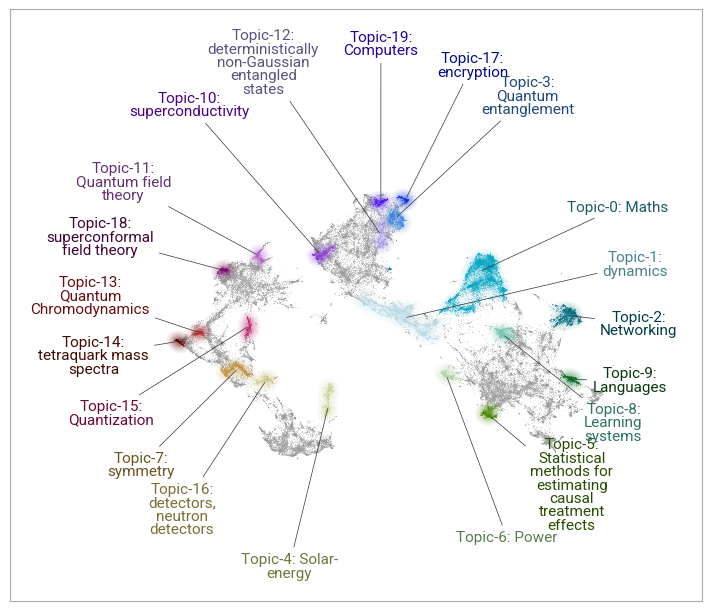

In [9]:
fig = topic_model.visualize_document_datamap(
    titles,
    title="",
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=600,  # 7인치에 해당하는 픽셀 수 (100 픽셀/인치 기준)
    height=600,  # 7인치에 해당하는 픽셀 수
    label_font_size=11,  # 텍스트 크기 축소
    label_wrap_width=15,  # 레이블 줄바꿈 너비 축소
    use_medoids=True,
)


In [18]:
# | echo: false
import gc

import torch

gc.collect()
torch.cuda.empty_cache()


## 프롬프트 엔지니어링

생성형 사전 학습 트랜스포머(GPT) 모델은 사용자가 제시한 프롬프트에 대응하여 텍스트를 생성하는 놀라운 능력을 갖추고 있습니다. 프롬프트 엔지니어링을 통해 이러한 프롬프트를 효과적으로 설계함으로써 생성되는 텍스트의 품질을 크게 향상시킬 수 있습니다. 

이번에는 이러한 생성형 모델에 대해 더 자세히 살펴보고, 프롬프트 엔지니어링의 세계로 깊이 들어가 보겠습니다. 또한 생성형 모델을 이용한 추론, 검증, 그리고 모델 출력의 평가 방법까지 다루어 볼 것입니다.

프롬프트 엔지니어링은 단순히 질문을 던지는 것을 넘어서, 모델이 원하는 방식으로 응답하도록 유도하는 기술입니다. 이는 모델의 성능을 최적화하고, 특정 작업에 맞춤화된 결과를 얻는 데 핵심적인 역할을 합니다.

In [ ]:
# | echo: false
import warnings

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시


In [4]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    logging,
    pipeline,
)

# 사용할 모델 이름 지정
model_name = "microsoft/Phi-3.5-mini-instruct"

# 모델 로드 및 설정
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="cuda",  # GPU 사용
    torch_dtype=torch.float16,  # 16비트 부동소수점 사용
    trust_remote_code=True,
)
# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 텍스트 생성 파이프라인 설정
pipe = pipeline(
    "text-generation",
    model=model,  # 모델 지정
    tokenizer=tokenizer,  # 토크나이저 지정
    return_full_text=False,  # 전체 텍스트 반환 안 함
    max_new_tokens=500,  # 최대 새 토큰 수
    do_sample=False,  # 샘플링 사용 안 함
)

# 프롬프트 설정
messages = [
    {
        "role": "user",
        "content": "직장동료에게 보내는 이메일의 짧은 인사말 3개만 적어줘.",
    }
]

# 출력 생성
output = pipe(messages)
# 생성된 텍스트 출력
print(output[0]["generated_text"])


`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are not running the flash-attention implementation, expect numerical differences.


 제목: 환영 인사드리기

안녕 친구,

안녕하세요! 이 이메일을 보내드리고 직장에 합류하게 되어 기쁩니다. 팀에서 함께 일하고 함께 성장하기를 기대합니다. 행운을 빌어요!

감사합니다,
[당신의 이름]


### 모델 출력 제어

모델 매개변수를 조정하여 원하는 종류의 출력을 제어할 수 있습니다. **temperature**와 **top_p** 매개변수는 출력의 무작위성을 제어합니다.

#### Temperature(온도)

Temperature는 생성된 텍스트의 무작위성 또는 창의성을 제어합니다. 이는 확률이 낮은 토큰을 선택할 가능성을 정의합니다. 기본 아이디어는 temperature가 0이면 항상 가장 가능성이 높은 단어를 선택하기 때문에 매번 동일한 응답을 생성한다는 것입니다.

#### top_p
top_p(핵 샘플링이라고도 함)는 LLM이 고려할 수 있는 토큰의 부분집합(핵)을 제어하는 샘플링 기법입니다. 누적 확률에 도달할 때까지 토큰을 고려합니다. top_p를 0.1로 설정하면 해당 값에 도달할 때까지 토큰을 고려합니다.

In [5]:
# Using a high temperature
output = pipe(messages, do_sample=True, temperature=1)
print(output[0]["generated_text"])


 제목: 안녕하세요, [동료 이름]

안녕하세요! 저를 잘 기억해주시고, 전문적인 지원과 협력을 이어오시길 바랍니다.

감사드립니다!

[당신의 이름]


In [6]:
# Using a high top_p
output = pipe(messages, do_sample=True, top_p=1)
print(output[0]["generated_text"])


 제목: 인사 릴렉센

---

1. 빠른 칭호와 행운을 바쳐:
   안녕하세요 [동료 이름],

   이 메시지를 전해드리며, 우리를 부러워하게 만드는 발신인 이 글을 통해 전하고자 합니다. 이 역할에서 네가 저녁부터 아침까지 우수하게 일하고 있다는 증거로 자리매김하는 것을 자랑스럽게 여깁니다.

2. 긍정적인 기여에 감사:
   네가 간략한 지원도 및 공유된 실력에 영향을 미친 프로젝트와 빈틈없는 팀플 작물에 큰 마스터피스를 제공해주셨습니다. 이 회사를 하나의 개인으로부터 더 강력하고 협력적인 집단으로 시간이 지나면서 지속적인 성장을 목격하고 있습니다.

3. 앞으로의 연결:
   이 인사의 마당에 더 나


### 고급 프롬프트 엔지니어링

좋은 프롬프트를 만드는 것은 간단해 보일 수 있습니다. 구체적인 질문을 하고, 정확하게 표현하며, 몇 가지 예시를 추가하면 끝난 것 같죠! 하지만 프롬프트 작성은 매우 빠르게 복잡해질 수 있으며, 그 결과 대규모 언어 모델(LLM)을 활용하는 데 있어 종종 과소평가되는 요소입니다. 여기서는 프롬프트를 구축하기 위한 여러 가지 고급 기법을 살펴보겠습니다.

### 복잡한 프롬프트

이 복잡한 프롬프트는 프롬프트 작성의 모듈식 특성을 보여줍니다. 우리는 자유롭게 구성 요소를 추가하거나 제거할 수 있고 출력에 미치는 영향을 판단할 수 있습니다.

In [14]:
# 프롬프트 구성 요소
persona = "당신은 인공지능과 기계학습 분야의 전문가입니다. 복잡한 기술 문서를 쉽게 이해할 수 있는 요약으로 만드는 데 탁월합니다.\n"
instruction = "제공된 기술 문서의 핵심 내용을 요약해주세요.\n"
context = "요약은 개발자들이 문서의 가장 중요한 정보를 빠르게 파악할 수 있도록 핵심 포인트를 추출해야 합니다.\n"
data_format = "주요 개념과 기술을 설명하는 글머리 기호 요약을 만드세요. 그 다음 주요 내용을 간결하게 요약하는 단락을 작성하세요.\n"
audience = "이 요약은 최신 AI 개발 동향을 빠르게 파악해야 하는 바쁜 개발자들을 위한 것입니다.\n"
tone = "전문적이고 명확한 톤을 사용해야 합니다.\n"

# 아래 내용을 원하는 문장으로 변경했습니다.
text = """
머신러닝 모델의 성능을 향상시키는 방법 중 하나는 앙상블 학습입니다. 앙상블 학습은 여러 개의 모델을 조합하여 더 나은 예측 결과를 얻는 방법입니다.
주요 앙상블 기법으로는 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking)이 있습니다.
배깅은 동일한 알고리즘을 사용하지만 서로 다른 학습 데이터 부분집합으로 여러 모델을 학습시키는 방법입니다.
부스팅은 이전 모델의 오류를 보완하는 방향으로 순차적으로 모델을 학습시키는 방법입니다.
스태킹은 여러 모델의 예측 결과를 새로운 모델의 입력으로 사용하여 최종 예측을 수행하는 방법입니다.
이러한 앙상블 기법들은 단일 모델보다 일반적으로 더 높은 성능과 안정성을 제공합니다.
"""

data = f"요약할 텍스트: {text}"

# 전체 프롬프트 - 생성된 출력에 미치는 영향을 보기 위해 부분을 제거하거나 추가할 수 있습니다
query = persona + instruction + context + data_format + audience + tone + data

messages = [{"role": "user", "content": query}]
print(tokenizer.apply_chat_template(messages, tokenize=False))

# 출력 생성
outputs = pipe(messages)
print(outputs[0]["generated_text"])


<|user|>
당신은 인공지능과 기계학습 분야의 전문가입니다. 복잡한 기술 문서를 쉽게 이해할 수 있는 요약으로 만드는 데 탁월합니다.
제공된 기술 문서의 핵심 내용을 요약해주세요.
요약은 개발자들이 문서의 가장 중요한 정보를 빠르게 파악할 수 있도록 핵심 포인트를 추출해야 합니다.
주요 개념과 기술을 설명하는 글머리 기호 요약을 만드세요. 그 다음 주요 내용을 간결하게 요약하는 단락을 작성하세요.
이 요약은 최신 AI 개발 동향을 빠르게 파악해야 하는 바쁜 개발자들을 위한 것입니다.
전문적이고 명확한 톤을 사용해야 합니다.
요약할 텍스트: 
머신러닝 모델의 성능을 향상시키는 방법 중 하나는 앙상블 학습입니다. 앙상블 학습은 여러 개의 모델을 조합하여 더 나은 예측 결과를 얻는 방법입니다.
주요 앙상블 기법으로는 배깅(Bagging), 부스팅(Boosting), 스태킹(Stacking)이 있습니다.
배깅은 동일한 알고리즘을 사용하지만 서로 다른 학습 데이터 부분집합으로 여러 모델을 학습시키는 방법입니다.
부스팅은 이전 모델의 오류를 보완하는 방향으로 순차적으로 모델을 학습시키는 방법입니다.
스태킹은 여러 모델의 예측 결과를 새로운 모델의 입력으로 사용하여 최종 예측을 수행하는 방법입니다.
이러한 앙상블 기법들은 단일 모델보다 일반적으로 더 높은 성능과 안정성을 제공합니다.
<|end|>
<|endoftext|>
 **요약: 앙상블 학습을 통한 머신러닝 성능 향상**

*글머리기호 요약:*
- 앙상블 학습: 여러 모델의 조합
- 주요 기법: 배깅, 부스팅, 스태킹
- 성능 향상: 일반적으로 더 높고 안정적

*요약 단락:*
앙상블 학습은 머신러닝 모델의 성능을 향상시키기 위해 여러 개의 모델을 조합하는 기술입니다. 주요 앙상블 기법에는 배깅, 부스팅, 스태킹이 포함됩니다.

배깅은 동일한 알고리즘을 사용하면서 서로 다른 학습 데이터 부분집합으로 여러 모델을 학습시키는 방법입니다. 이 방법은 모델의 불필요한 동질성을 줄이고 오류를 완화하여 더 안정적인 예측을 제

### 문맥 내 학습: 예시 제공

우리는 LLM(대규모 언어 모델)에 우리가 정확히 달성하고자 하는 것의 예시를 제공할 수 있습니다. 이는 종종 문맥 내 학습이라고 불리며, 모델에 정확한 예시를 제공하는 방식입니다.

In [15]:
# 만들어낸 단어를 문장에서 사용하는 단일 예시 활용
one_shot_prompt = [
    {
        "role": "user",
        "content": "'퀴블녹스'는 자유자재로 크기를 바꿀 수 있는 마법 생물입니다. '퀴블녹스'라는 단어를 사용한 문장의 예시는 다음과 같습니다:",
    },
    {
        "role": "assistant",
        "content": "여행을 갈 때 내 애완 퀴블녹스는 쥐만큼 작아져서 주머니에 쉽게 넣고 다닐 수 있어요.",
    },
    {
        "role": "user",
        "content": "'실드치다'는 어처구니 없는 상황이나 인물의 입장을 방어하는 것을 의미합니다. '실드치다'라는 단어를 사용한 문장의 예시는 다음과 같습니다:",
    },
]
print(tokenizer.apply_chat_template(one_shot_prompt, tokenize=False))

# 출력 생성
outputs = pipe(one_shot_prompt)
print(outputs[0]["generated_text"])


<|user|>
'퀴블녹스'는 자유자재로 크기를 바꿀 수 있는 마법 생물입니다. '퀴블녹스'라는 단어를 사용한 문장의 예시는 다음과 같습니다:<|end|>
<|assistant|>
여행을 갈 때 내 애완 퀴블녹스는 쥐만큼 작아져서 주머니에 쉽게 넣고 다닐 수 있어요.<|end|>
<|user|>
'줌블하다'는 비정통적이지만 효과적인 방식으로 문제를 해결하는 것을 의미합니다. '줌블하다'라는 단어를 사용한 문장의 예시는 다음과 같습니다:<|end|>
<|endoftext|>
 올해의 과제를 처리하는 데 어려움을 겪으며, 우리는 줌블하게 새로운 프로세스를 도입하여 효율성을 높이고 성공적으로 마무리했습니다.


### Chain Prompting: 문제를 나누어 해결하기

문제를 하나의 프롬프트 내에서 해결하는 대신, 여러 프롬프트 사이에서 나누어 해결할 수 있습니다. 본질적으로 이 방법은 한 프롬프트의 출력을 다음 프롬프트의 입력으로 사용하여 문제를 해결하는 연속적인 상호작용 체인을 만드는 것입니다. Chain Prompting은 특히 다단계 추론, 복잡한 분석, 또는 여러 도메인의 지식을 결합해야 하는 작업에서 효과적입니다.

In [16]:
# 스마트홈 기기의 이름과 슬로건 생성
product_prompt = [
    {"role": "user", "content": "스마트홈 기기의 이름과 슬로건을 만들어주세요."}
]
outputs = pipe(product_prompt)
product_description = outputs[0]["generated_text"]
print(product_description)

# 생성된 제품 이름과 슬로건을 바탕으로 짧은 판매 문구 생성
sales_prompt = [
    {
        "role": "user",
        "content": f"다음 제품에 대한 매우 짧은 판매 문구를 생성해주세요: '{product_description}'",
    }
]
outputs = pipe(sales_prompt)
sales_pitch = outputs[0]["generated_text"]
print(sales_pitch)


 이름: "SmartHaven"

슬로건: "SmartHaven - 디지털 편안함, 현실 속 편안한 집."

SmartHaven는 스마트홈 기기의 편안함과 효율성을 실현하는 최첨단 기기로, 집의 모든 영역에서 디지털 혁신을 제공합니다. 이 기기는 생활의 질을 향상시키고, 집의 안전성을 강화하며, 사용자의 생활을 효율적이고 편안하게 만듭니다. SmartHaven의 디지털 편안함과 현실 속 편안한 집을 상징하는 슬로건은 이러한 기능을 강조하고, 소비자들이 스마트홈의 풍부한 가치를 느낄 수 있도록 합니다.
 "SmartHaven: 현실 속 편안한 집, 디지털 편안함을 누릴 순간."


### 생성형 모델을 이용한 추론

추론은 인간 지능의 핵심 요소이며 종종 추론과 유사해 보이는 LLM의 창발적 행동과 비교됩니다. 우리가 "유사해 보이는"이라고 강조하는 이유는 이 글을 쓰는 시점에서 이러한 모델들은 일반적으로 학습 데이터의 암기와 패턴 매칭을 통해 이러한 행동을 보여주는 것으로 여겨지기 때문입니다.

### Chain-of-Thought: 답변 전에 생각하기

Chain-of-Thought(사고 연쇄)는 생성형 모델이 질문에 직접 답변하지 않고 먼저 "생각"하도록 하는 것을 목표로 합니다.Chain-of-Thought 방식은 특히 수학 문제 풀이, 논리 퍼즐, 복잡한 의사 결정 과정 등에서 효과적으로 사용될 수 있으며, 모델의 추론 능력을 향상시키는 데 도움이 됩니다.

In [17]:
# 명시적인 추론 없이 답변하기
standard_prompt = [
    {
        "role": "user",
        "content": "민수는 색연필 12자루를 가지고 있었습니다. 새 색연필 세트를 받았는데, 그 세트에는 8자루가 들어있었습니다. 그런데 3자루를 동생에게 주었습니다. 민수는 지금 몇 자루의 색연필을 가지고 있나요?",
    },
    {"role": "assistant", "content": "17"},
    {
        "role": "user",
        "content": "학교 도서관에 책이 300권 있었습니다. 새로운 책 50권을 구입했고, 학생들이 25권을 빌려갔습니다. 지금 도서관에 있는 책은 몇 권인가요?",
    },
]

# 생성 모델 실행
outputs = pipe(standard_prompt)
print(outputs[0]["generated_text"])


 325권

이 문제를 해결하기 위해서는 다음 단계를 따릅니다:

1. 도서관에는 초기에 300권의 책이 있었습니다.
2. 새로운 책 50권을 도서관에 추가했습니다. 이를 기존의 총 권수에 더합니다: 300 + 50 = 350권.
3. 그런 다음, 학생들이 25권을 빌려갔습니다. 이를 현재의 총 권수에서 빼야 합니다: 350 - 25 = 325권.

따라서, 도서관에는 현재 325권의 책이 남아 있습니다.


In [18]:
# 사고 과정을 포함한 답변
cot_prompt = [
    {
        "role": "user",
        "content": "민수는 색연필 12자루를 가지고 있었습니다. 새 색연필 세트를 2개 받았는데, 각 세트에는 5자루가 들어있었습니다. 민수는 지금 몇 자루의 색연필을 가지고 있나요?",
    },
    {
        "role": "assistant",
        "content": "민수는 처음에 12자루의 색연필을 가지고 있었습니다. 2개의 새 세트에 각각 5자루씩 들어있으므로 10자루를 추가로 받았습니다. 12 + 10 = 22. 따라서 답은 22자루입니다.",
    },
    {
        "role": "user",
        "content": "학교 도서관에 책이 45권 있었습니다. 15권을 학생들에게 대출해주고 새로운 책 20권을 구입했습니다. 지금 도서관에 있는 책은 몇 권인가요?",
    },
]

# 출력 생성
outputs = pipe(cot_prompt)
print(outputs[0]["generated_text"])


 도서관에서는 처음에 45권의 책이 있었습니다. 15권을 학생들에게 대출했으므로 45 - 15 = 30권이 남았습니다. 그런 다음 20권의 새로운 책을 구입했으므로 30 + 20 = 50권의 책이 지금 도서관에 있습니다. 따라서 답은 50권입니다.


### 제로샷 Chain-of-Thought

모델에게 예시를 제공하는 대신에 우리는 단순히 생성형 모델에게 추론 과정을 제공하도록 요청할 수 있습니다(제로샷 chain-of-thought). 이를 위해 효과적인 다양한 형태가 있지만 흔하고 효과적인 방법 중 하나는 "단계별로 생각해 봅시다"라는 문구를 사용하는 것입니다. 이 방법은 특히 다양한 유형의 문제에 대해 빠르게 추론 과정을 얻고자 할 때 유용하며, 모델의 일반화된 추론 능력을 테스트하는 데에도 효과적입니다.

In [19]:
# Zero-shot Chain-of-Thought
zeroshot_cot_prompt = [
    {
        "role": "user",
        "content": "도서관에 책이 50권 있었습니다. 15권을 대출해주고 새로 20권을 구입했습니다. 지금 도서관에 있는 책은 몇 권인가요? 단계별로 생각해봅시다.",
    }
]

# 출력 생성
outputs = pipe(zeroshot_cot_prompt)
print(outputs[0]["generated_text"])


 이 문제를 해결하기 위해 다음 단계를 따르겠습니다:

1. 도서관에서 시작하는 초기 책 수: 50권
2. 대출된 책 수: 15권
3. 구입한 새로운 책 수: 20권

이제 이 값을 사용하여 현재 도서관에 있는 책 수를 계산해봅시다:

1. 시작하는 초기 책 수에서 대출된 책 수를 빼줍니다: 50 - 15 = 35권
2. 이 결과에 구입한 새로운 책 수를 더합니다: 35 + 20 = 55권

따라서, 현재 도서관에는 55권의 책이 있습니다.


### Tree-of-Thought: 중간 단계 탐색하기
Chain-of-Thought와 자기 일관성(self-consistency)의 개념은 더 복잡한 추론을 가능하게 하기 위한 것입니다. 여러 "생각"들을 샘플링하고 이를 더 신중하게 만듦으로써 생성형 모델의 출력을 개선합니다.


In [20]:
# Zero-shot Tree-of-Thought
zeroshot_tot_prompt = [
    {
        "role": "user",
        "content": "세 명의 다른 전문가들이 이 질문에 답하고 있다고 상상해보세요. 모든 전문가는 자신의 생각의 1단계를 적은 다음 그룹과 공유합니다. 그런 다음 모든 전문가는 다음 단계로 넘어갑니다. 만약 어느 전문가라도 자신이 틀렸다는 것을 깨닫게 되면 그 즉시 토론에서 빠집니다. 질문은 '학교 도서관에 책이 80권 있었습니다. 30권을 학생들에게 대출해주고 새로운 책 25권을 구입했습니다. 지금 도서관에 있는 책은 몇 권인가요?' 입니다. 결과에 대해 반드시 토론해주세요.",
    }
]

# 출력 생성
outputs = pipe(zeroshot_tot_prompt)
print(outputs[0]["generated_text"])


 1단계: 초기 책 수를 기억하기
80권의 책이 도서관에서 시작합니다.

2단계: 학생들에게 대출된 책 수를 계산하기
30권의 책이 학생들에게 대출됩니다.

3단계: 구입한 새로운 책 수를 계산하기
25권의 새로운 책이 도서관에 추가됩니다.

4단계: 현재 책 수를 계산하기
1단계에서 시작한 80권에서 2단계의 30권을 빼고, 그리고 3단계의 25권을 더합니다.

80 - 30 = 50
50 + 25 = 75

토론:
도서관에는 80권의 책이 시작되었습니다. 그 다음, 30권의 책이 학생들에게 대출되었습니다. 이로 인해 도서관에는 50권의 책이 남았습니다. 그 다음, 25권의 새로운 책이 도서관에 추가되었습니다. 따


## 의미론적 검색 및 검색 증강 생성

### 밀집 검색 (Dense Retrieval)

밀집 검색은 검색 쿼리가 관련 결과와 가까울 것이라는 특성에 의존합니다.

#### 밀집 검색 주의사항

- 거짓 양성: 의미적으로 유사하지만 실제로 관련이 없는 결과를 반환할 수 있습니다.
- 답변 부재: 코퍼스에 답변이 없는 경우에도 가장 가까운 결과를 반환합니다.
- 컨텍스트 손실: 단어의 정확한 일치보다는 의미적 유사성에 중점을 두기 때문에 특정 키워드나 구문을 놓칠 수 있습니다.
- 계산 비용: 대규모 데이터셋에서는 계산 비용이 높을 수 있습니다.
- 도메인 특화의 어려움: 특정 도메인의 전문 용어나 개념을 정확히 포착하기 어려울 수 있습니다.

In [20]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


In [21]:
import torch
from transformers import (
    DPRContextEncoder,
    DPRContextEncoderTokenizer,
    DPRQuestionEncoder,
    DPRQuestionEncoderTokenizer,
)

question_model = "facebook/dpr-question_encoder-single-nq-base"
context_model = "facebook/dpr-ctx_encoder-single-nq-base"

# 인코더와 토크나이저 초기화
question_encoder = DPRQuestionEncoder.from_pretrained(question_model)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained(question_model)
context_encoder = DPRContextEncoder.from_pretrained(context_model)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained(context_model)

# 질문 인코딩
question = "듄의 작가는 누구인가요?"
question_input = question_tokenizer(question, return_tensors="pt")
question_embedding = question_encoder(**question_input).pooler_output

# 컨텍스트 인코딩
context = "듄은 1965년에 미국 작가 프랭크 허버트가 쓴 공상과학 소설입니다."
context_input = context_tokenizer(context, return_tensors="pt")
context_embedding = context_encoder(**context_input).pooler_output

# 유사도 계산
similarity = torch.matmul(question_embedding, context_embedding.transpose(0, 1))
print(f"유사도 점수: {similarity.item():.4f}")


유사도 점수: 75.5189


### 재순위화 예시

재순위화 시스템(예: monoBERT)은 사용자의 검색어와 후보 결과들을 분석하여 각 문서가 해당 검색어와 얼마나 관련이 있는지 점수를 매깁니다. 이렇게 산출된 관련성 점수를 바탕으로 사전에 선별된 결과들의 순서를 재배열합니다. 이 과정을 통해 검색어에 대한 결과의 순위가 개선되어 더욱 정확하고 관련성 높은 정보를 상위에 표시할 수 있게 됩니다.

재순위화 시스템의 주요 특징은 다음과 같습니다:

1. **정교한 관련성 평가**: 단순한 키워드 매칭을 넘어 문맥과 의미를 고려한 심층적인 관련성 평가를 수행합니다.

2. **맞춤형 순위 조정**: 사용자의 검색 의도를 더 정확히 반영하여 결과의 순위를 조정합니다.

3. **검색 품질 향상**: 사용자에게 더 관련성 높고 유용한 정보를 우선적으로 제공함으로써 전반적인 검색 경험을 개선합니다.

4. **다양한 요소 고려**: 문서의 내용, 구조, 메타데이터 등 다양한 요소를 종합적으로 분석하여 순위를 결정합니다.

In [22]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
# 재순위화 모델 로드
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 예시 쿼리와 검색된 문단들
query = "프랑스의 수도는 어디인가요?"
passages = [
    "파리는 프랑스의 수도이자 가장 인구가 많은 도시입니다.",
    "런던은 영국과 잉글랜드의 수도입니다.",
    "프랑스는 서유럽에 위치한 국가입니다.",
]

# 문단 재순위화
pairs = [[query, passage] for passage in passages]
inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    scores = model(**inputs).logits.squeeze(-1)

# 점수에 따라 문단 정렬
reranked_passages = [p for _, p in sorted(zip(scores, passages), reverse=True)]

print("재순위화된 문단:")
for i, passage in enumerate(reranked_passages, 1):
    print(f"{i}. {passage}")


재순위화된 문단:
1. 파리는 프랑스의 수도이자 가장 인구가 많은 도시입니다.
2. 런던은 영국과 잉글랜드의 수도입니다.
3. 프랑스는 서유럽에 위치한 국가입니다.


### RAG(검색 증강 생성)

RAG는 검색 시스템의 파이프라인 끝단에 생성형 대규모 언어 모델(LLM)을 배치하는 혁신적인 접근 방식입니다. 이 방법을 통해 시스템은 검색된 문서를 바탕으로 답변을 생성하면서 동시에 출처를 인용할 수 있습니다. RAG의 주요 특징과 장점은 다음과 같습니다:

1. **정보의 정확성과 최신성**: 실시간으로 검색된 최신 정보를 바탕으로 답변을 생성하므로, 항상 최신의 정확한 정보를 제공할 수 있습니다.

2. **근거 기반 응답**: 생성된 답변의 각 부분에 대해 출처를 제시함으로써, 사용자는 정보의 신뢰성을 직접 확인할 수 있습니다.

3. **유연한 지식 확장**: 모델의 재학습 없이도 새로운 정보를 즉시 활용할 수 있어, 지식 기반을 지속적으로 확장할 수 있습니다.

4. **맥락 이해 능력 향상**: 검색된 문서들의 맥락을 종합적으로 이해하여 더 깊이 있고 관련성 높은 답변을 생성합니다.

5. **투명성 제고**: 정보의 출처를 명확히 제시함으로써 AI 시스템의 의사결정 과정을 더 투명하게 만듭니다.

In [24]:
import torch
from transformers import (
    AutoModel,
    AutoTokenizer,
    RagRetriever,
    RagSequenceForGeneration,
)

# 사전 훈련된 모델 로드
question_encoder = AutoModel.from_pretrained(
    "facebook/dpr-question_encoder-single-nq-base"
)
question_tokenizer = AutoTokenizer.from_pretrained(
    "facebook/dpr-question_encoder-single-nq-base"
)
generator_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")

# RAG 컴포넌트 초기화
retriever = RagRetriever.from_pretrained(
    "facebook/rag-sequence-nq", index_name="exact", use_dummy_dataset=True
)
model = RagSequenceForGeneration.from_pretrained(
    "facebook/rag-sequence-nq", retriever=retriever
)


def generate_answer(query):
    # 쿼리 인코딩
    input_ids = question_tokenizer(query, return_tensors="pt")["input_ids"]
    question_hidden_states = question_encoder(input_ids)[0]

    # 관련 문서 검색
    retriever_output = retriever(input_ids, question_hidden_states, return_tensors="pt")

    # 답변 생성
    input_ids = retriever_output["input_ids"]
    attention_mask = retriever_output["attention_mask"]
    output = model.generate(input_ids=input_ids, attention_mask=attention_mask)

    # 생성된 답변 디코딩 및 반환
    return generator_tokenizer.decode(output[0], skip_special_tokens=True)


# 사용 예시
query = "프랑스의 수도는 어디인가요?"
answer = generate_answer(query)
print(f"질문: {query}")
print(f"답변: {answer}")


In [3]:
# | echo: false
import gc
import warnings

import torch
from transformers import logging

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


## 멀티모달 LLM

대규모 언어 모델(LLM)에서는 멀티모달 입력을 받아들이고 이를 바탕으로 추론하는 능력은 이전에는 접근하기 어려웠던 새로운 가능성을 열어줄 수 있습니다. 여기에서는 멀티모달 기능을 갖춘 여러 LLM을 살펴보고 실제 사용 사례로 어떤 의미를 갖는지 알아볼 것입니다.

### CLIP(텍스트와 이미지 연결)

CLIP은 이미지와 텍스트 모두의 임베딩을 계산할 수 있는 임베딩 모델입니다. CLIP은 컴퓨터 비전과 자연어 처리의 경계를 허물고 두 영역을 통합하는 강력한 도구로 자리잡고 있습니다. 이를 통해 AI 시스템은 인간의 의사소통 방식에 더 가까워지고 더욱 자연스럽고 직관적인 상호작용이 가능해집니다. CLIP의 주요 특징은 다음과 같습니다:

1. **통합된 표현 공간**: 이미지와 텍스트를 동일한 벡터 공간에 표현하여 직접적인 비교가 가능합니다.
2. **크로스모달 학습**: 이미지와 텍스트 사이의 관계를 학습하여 더 풍부한 이해를 가능하게 합니다.
3. **유연한 응용**: 이미지 검색, 이미지 캡셔닝, 시각적 질의응답 등 다양한 작업에 활용될 수 있습니다.
4. **제로샷 학습 능력**: 특정 작업에 대한 추가 학습 없이도 새로운 개념을 인식할 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


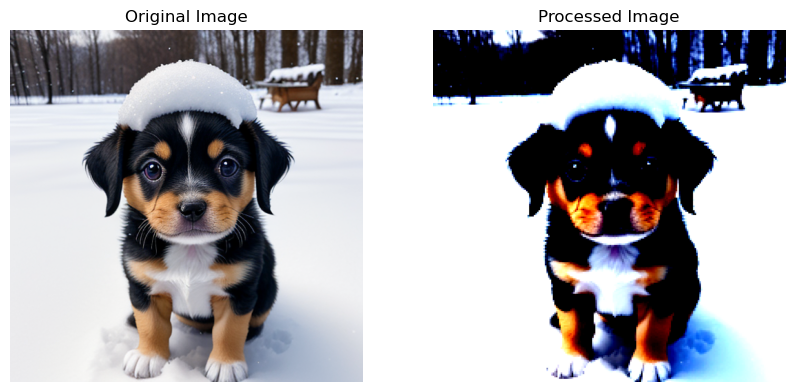

유사도 점수: 0.3006


In [2]:
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

# 이미지 불러오기
image_url = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(image_url)).convert("RGB")
caption = "A ppuppy playing in the snow"
model_id = "openai/clip-vit-base-patch32"

# 텍스트 전처리를 위한 토크나이저 로드
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# 이미지 전처리를 위한 프로세서 로드
clip_processor = CLIPProcessor.from_pretrained(model_id)

# 텍스트 및 이미지 임베딩 생성을 위한 주 모델
model = CLIPModel.from_pretrained(model_id)

# 입력 토큰화
inputs = clip_tokenizer(caption, return_tensors="pt")

# 텍스트 임베딩 생성
text_embedding = model.get_text_features(**inputs)

# 이미지 전처리
processed_image = clip_processor(text=None, images=image, return_tensors="pt")[
    "pixel_values"
]

# 이미지 임베딩 생성
image_embedding = model.get_image_features(processed_image)

# 시각화를 위한 이미지 준비
processed_img = processed_image.squeeze(0)
processed_img = processed_img.permute(*torch.arange(processed_img.ndim - 1, -1, -1))
processed_img = np.einsum("ijk->jik", processed_img.numpy())

# 원본 이미지와 처리된 이미지 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.set_title("Original Image")
ax1.axis("off")
ax2.imshow(processed_img)
ax2.set_title("Processed Image")
ax2.axis("off")
plt.show()

# 임베딩 정규화
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# 유사도 계산
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
print(f"유사도 점수: {score.item():.4f}")


### BLIP-2(양식 간 격차 해소)

처음부터 멀티모달 언어 모델을 만드는 것은 엄청난 컴퓨팅 파워와 데이터를 필요로 합니다. 이러한 모델을 만들려면 수십억 개의 이미지, 텍스트, 그리고 이미지-텍스트 쌍을 사용해야 합니다. 이는 쉽게 실현 가능한 일이 아닙니다. BLIP-2는 이러한 어려움을 해결하기 위해 새로운 접근 방식을 취합니다. 처음부터 아키텍처를 구축하는 대신, 사전 학습된 이미지 인코더와 사전 학습된 LLM을 연결하는 '쿼리 트랜스포머(Q-Former)'라는 다리를 구축하여 시각-언어 간의 격차를 해소합니다. 이 방식의 주요 장점은 다음과 같습니다:

1. **효율적인 학습**: BLIP-2는 이미지 인코더와 LLM을 처음부터 학습할 필요 없이 연결 다리만 학습하면 됩니다.
2. **기존 기술 활용**: 이미 존재하는 기술과 모델을 최대한 활용하여 효율성을 높입니다.
3. **유연성**: 다양한 사전 학습 모델을 조합하여 사용할 수 있어, 특정 작업에 최적화된 구성을 만들 수 있습니다.
4. **성능 향상**: 각 분야에서 최고의 성능을 보이는 모델들을 결합함으로써 전반적인 성능을 크게 향상시킬 수 있습니다.
5. **자원 절약**: 거대한 데이터셋과 컴퓨팅 자원이 필요한 전체 모델 학습을 피할 수 있어 시간과 비용을 절약합니다.

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

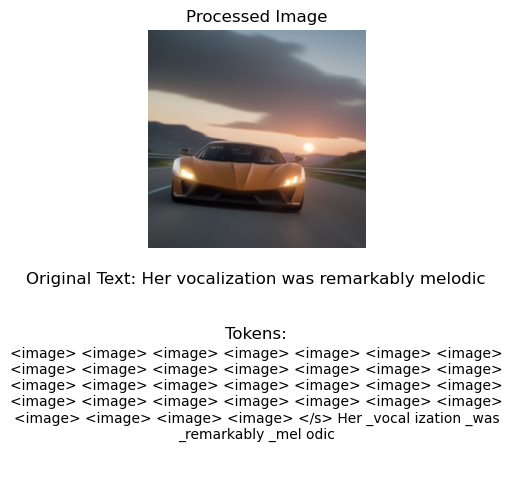

In [3]:
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModelForVisualQuestionAnswering, AutoProcessor

# 프로세서와 주 모델 로드
blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
)
model = AutoModelForVisualQuestionAnswering.from_pretrained(
    "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16
)

# 추론 속도 향상을 위해 모델을 GPU로 이동
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 슈퍼카 이미지 로드
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")

# 이미지 전처리
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

# numpy로 변환하고 (1, 3, 224, 224)에서 (224, 224, 3) 형태로 변경
image_inputs = inputs["pixel_values"][0].detach().cpu().numpy()
image_inputs = np.einsum("ijk->kji", image_inputs)
image_inputs = np.einsum("ijk->jik", image_inputs)

# RGB 값을 나타내기 위해 이미지 입력을 0-255로 스케일링
scaler = MinMaxScaler(feature_range=(0, 255))
image_inputs = scaler.fit_transform(
    image_inputs.reshape(-1, image_inputs.shape[-1])
).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# numpy 배열을 Image로 변환
Image.fromarray(image_inputs)

# 텍스트 전처리
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# 입력 ID를 다시 토큰으로 변환
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)

# 공백 토큰을 밑줄로 대체
tokens = [token.replace("Ġ", "_") for token in tokens]

# 시각화
plt.figure(figsize=(5, 5))

# 이미지 표시
plt.subplot(2, 1, 1)
plt.imshow(Image.fromarray(image_inputs))
plt.title("Processed Image")
plt.axis("off")

# 텍스트와 토큰 표시
plt.subplot(2, 1, 2)
plt.text(
    0.5,
    0.9,
    f"Original Text: {text}",
    horizontalalignment="center",
    fontsize=12,
    wrap=True,
)
plt.text(0.5, 0.65, "Tokens:", horizontalalignment="center", fontsize=12)
plt.text(
    0.5, 0.2, " ".join(tokens), horizontalalignment="center", fontsize=10, wrap=True
)
plt.axis("off")

plt.tight_layout()
plt.show()


#### 사용 사례 1: 이미지 캡셔닝
이미지 캡셔닝은 주어진 이미지의 내용을 설명하는 텍스트를 자동으로 생성하는 작업입니다. 

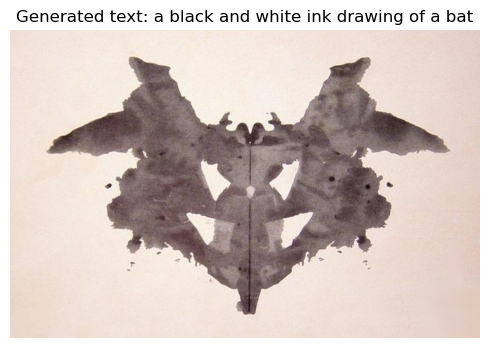

In [28]:
# 이미지 로드
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# 캡션 생성
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()

# 이미지와 생성된 텍스트 시각화
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(f"Generated text: {generated_text}", fontsize=12)
plt.tight_layout()
plt.show()


#### 사용 사례 2: 시각적 질의응답

시각적 질의응답은 이미지와 관련된 질문에 대해 AI가 답변을 제공하는 기술입니다. 

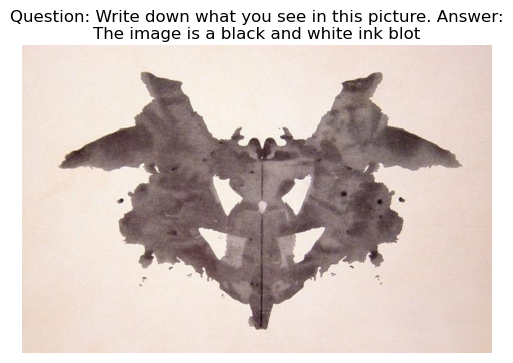

In [29]:
# 이미지 로드
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# 시각적 질문 답변
prompt = "Question: Write down what you see in this picture. Answer:"

# 이미지와 프롬프트 처리
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(
    device, torch.float16
)

# 텍스트 생성
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()

# 이미지와 생성된 텍스트 시각화
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(f"{generated_text}", fontsize=12, wrap=True)
plt.tight_layout()
plt.show()


In [30]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


이러한 다중 모달 텍스트 생성 모델의 핵심 아이디어는 입력 이미지의 시각적 특징을 LLM이 사용할 수 있는 텍스트 임베딩으로 투영하는 것입니다. 이 모델을 이미지 캡셔닝과 다중 모달 채팅 기반 프롬프팅에 사용하는 방법을 보았는데, 여기서는 두 가지 양식을 결합하여 응답을 생성합니다.

# 언어 모델 훈련 및 미세 조정

## 텍스트 임베딩 모델 생성

텍스트 임베딩 모델은 많은 강력한 자연어 처리 애플리케이션의 기초를 이룹니다. 이들은 텍스트 생성 모델과 같은 이미 인상적인 기술들을 더욱 강화하는 기반을 마련합니다. 임베딩 모델을 생성하는 방법은 여러 가지가 있지만, 일반적으로 우리는 대조 학습을 주목합니다. 이는 많은 임베딩 모델의 중요한 측면인데, 이 과정을 통해 모델이 의미론적 표현을 효율적으로 학습할 수 있기 때문입니다.

### 대조 생성(Generating Contrastive) 예제

In [1]:
import random

from datasets import Dataset, load_dataset
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from tqdm import tqdm

# GLUE에서 MNLI 데이터셋 로드
mnli = load_dataset("glue", "mnli", split="train").select(range(50_000))
mnli = mnli.remove_columns("idx")
mnli = mnli.filter(lambda x: True if x["label"] == 0 else False)

# 데이터 전처리
train_dataset = {"anchor": [], "positive": [], "negative": []}
soft_negatives = mnli["hypothesis"]
random.shuffle(soft_negatives)
for row, soft_negative in tqdm(zip(mnli, soft_negatives)):
    train_dataset["anchor"].append(row["premise"])
    train_dataset["positive"].append(row["hypothesis"])
    train_dataset["negative"].append(soft_negative)
train_dataset = Dataset.from_dict(train_dataset)

# 모델
embedding_model = SentenceTransformer("bert-base-uncased")

# 손실 함수 정의. 소프트맥스 손실에서는 레이블 수를 명시적으로 설정해야 함.
train_loss = losses.MultipleNegativesRankingLoss(model=embedding_model)

# 평가 함수 및 stsb를 위한 임베딩 유사도 평가기 생성
val_sts = load_dataset("glue", "stsb", split="validation")
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score / 5 for score in val_sts["label"]],
    main_similarity="cosine",
)

# 훈련 인자 정의
args = SentenceTransformerTrainingArguments(
    output_dir="mnrloss_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# 임베딩 모델 훈련
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator,
)
trainer.train()

# 훈련된 모델 평가
evaluator(embedding_model)


16875it [00:00, 42644.51it/s]
No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


Step,Training Loss
100,0.346900
200,0.107100
300,0.083700
400,0.068100
500,0.072500


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'pearson_cosine': np.float64(0.8058287434682441),
 'spearman_cosine': np.float64(0.8093139517546301)}

In [2]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


### 임베딩 모델의 미세 조정

#### 지도 학습 기반 미세 조정 (Supervised Fine-Tuning, SFT)

지도 학습 기반 미세 조정(SFT)은 사전 훈련된 임베딩 모델을 특정 작업이나 도메인에 맞게 조정하는 프로세스입니다. 이 방법은 레이블이 지정된 데이터셋을 사용하여 모델의 성능을 향상시키고 특정 용도에 더 적합하게 만듭니다.

In [3]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments

# GLUE에서 MNLI 데이터셋 로드
# 0 = 함의, 1 = 중립, 2 = 모순
train_dataset = load_dataset("glue", "mnli", split="train").select(range(25_000))
train_dataset = train_dataset.remove_columns("idx")

# stsb를 위한 임베딩 유사도 평가기 생성
val_sts = load_dataset("glue", "stsb", split="validation")
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score / 5 for score in val_sts["label"]],
    main_similarity="cosine",
)

# 모델 정의
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# 손실 함수
train_loss = losses.MultipleNegativesRankingLoss(model=embedding_model)

# 훈련 인자 정의
args = SentenceTransformerTrainingArguments(
    output_dir="finetuned_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100,
)

# 모델 훈련
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator,
)
trainer.train()

# 훈련된 모델 평가
evaluator(embedding_model)


Column 'hypothesis' is at index 1, whereas a column with this name is usually expected at index 0. Note that the column order can be important for some losses, e.g. MultipleNegativesRankingLoss will always consider the first column as the anchor and the second as the positive, regardless of the dataset column names. Consider renaming the columns to match the expected order, e.g.:
dataset = dataset.select_columns(['hypothesis', 'entailment', 'contradiction'])


Step,Training Loss
100,0.127500
200,0.126100
300,0.108700
400,0.117500
500,0.115400
600,0.105800
700,0.106100


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'pearson_cosine': np.float64(0.850360102427649),
 'spearman_cosine': np.float64(0.8505789375274108)}

In [3]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


### 비지도 학습

현실 세계의 데이터셋에는 우리가 사용할 수 있는 좋은 레이블 세트가 함께 제공되지 않습니다. 대신 미리 정해진 레이블 없이 모델을 훈련시키는 기법을 찾아야 합니다.
이것을 비지도 학습이라 부릅니다. 여기에는 여러 가지 방식이 존재합니다.

#### 트랜스포머 기반 순차적 디노이징 오토인코더

TSDAE는 비지도 학습으로 임베딩 모델을 만드는 매우 우아한 접근 방식입니다. 이 방법은 우리가 전혀 레이블이 지정된 데이터를 가지고 있지 않다고 가정하며, 인위적으로 레이블을 만들 필요가 없습니다.

In [2]:
import nltk
from datasets import Dataset, load_dataset
from sentence_transformers import SentenceTransformer, losses, models
from sentence_transformers.datasets import DenoisingAutoEncoderDataset
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from tqdm import tqdm

# 추가 토크나이저 다운로드
nltk.download("punkt")
nltk.download("punkt_tab")

# 문장의 평면 리스트 생성
mnli = load_dataset("glue", "mnli", split="train").select(range(25_000))
flat_sentences = mnli["premise"] + mnli["hypothesis"]

# 입력 데이터에 노이즈 추가
damaged_data = DenoisingAutoEncoderDataset(list(set(flat_sentences)))

# 데이터셋 생성
train_dataset = {"damaged_sentence": [], "original_sentence": []}
for data in tqdm(damaged_data):
    train_dataset["damaged_sentence"].append(data.texts[0])
    train_dataset["original_sentence"].append(data.texts[1])
train_dataset = Dataset.from_dict(train_dataset)

# stsb를 위한 임베딩 유사도 평가기 생성
val_sts = load_dataset("glue", "stsb", split="validation")
evaluator = EmbeddingSimilarityEvaluator(
    sentences1=val_sts["sentence1"],
    sentences2=val_sts["sentence2"],
    scores=[score / 5 for score in val_sts["label"]],
    main_similarity="cosine",
)

# 임베딩 모델 생성
word_embedding_model = models.Transformer("bert-base-uncased")
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(), "cls"
)
embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# 디노이징 오토인코더 손실 사용
train_loss = losses.DenoisingAutoEncoderLoss(embedding_model, tie_encoder_decoder=True)
train_loss.decoder = train_loss.decoder.to("cuda")

# 훈련 인자 정의
args = SentenceTransformerTrainingArguments(
    output_dir="tsdae_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=1000,
    disable_tqdm=False,
)

# 모델 훈련
trainer = SentenceTransformerTrainer(
    model=embedding_model,
    args=args,
    train_dataset=train_dataset,
    loss=train_loss,
    evaluator=evaluator,
)

trainer.train()

# 훈련된 모델 평가
evaluator(embedding_model)


[nltk_data] Downloading package punkt to /home/fkt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/fkt/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|█████████████████████| 48353/48353 [00:03<00:00, 15391.05it/s]


Step,Training Loss
1000,4.637300
2000,3.883400
3000,3.647900


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'pearson_cosine': np.float64(0.7401165281596465),
 'spearman_cosine': np.float64(0.7469963144425136)}

In [13]:
# VRAM clean up
import gc

import torch

gc.collect()
torch.cuda.empty_cache()


## 분류를 위한 표현 모델 미세 조정

BERT 모델을 미세 조정하는 여러 방법과 응용 사례를 살펴보겠습니다.

### 지도 학습 분류

사전 학습된 BERT 모델 미세 조정하기위해 앞서 사용했던 것과 동일한 Rotten Tomatoes 데이터셋을 활용하겠습니다. 영어 위키피디아와 미출판 도서들로 구성된 대규모 데이터셋으로 사전 학습된 "bert-base-cased" 모델을 사용할 것입니다.

In [1]:
import warnings

import evaluate
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    logging,
)

logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
warnings.filterwarnings("ignore")  # 경고 메시지 끄기

# 데이터 준비 및 분할
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

# 모델 및 토크나이저 로드
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 배치 내 가장 긴 시퀀스에 맞춰 패딩
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


def preprocess_function(examples):
    """입력 데이터 토큰화"""
    return tokenizer(examples["text"], truncation=True)


# 학습/테스트 데이터 토큰화
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}


# 매개변수 튜닝을 위한 학습 인자
training_args = TrainingArguments(
    "model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none",
    disable_tqdm=False,
)

# 학습 과정을 실행하는 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()

# 결과 평가
trainer.evaluate()


Step,Training Loss
500,0.418000
1000,0.234400
1500,0.137900
2000,0.072600
2500,0.038000
3000,0.032400
3500,0.023500
4000,0.007000
4500,0.010100
5000,0.004100


{'eval_loss': 1.279144048690796,
 'eval_f1': 0.8457899716177862,
 'eval_runtime': 1.4511,
 'eval_samples_per_second': 734.612,
 'eval_steps_per_second': 46.172,
 'epoch': 10.0}

### 적은 샷(Few shot) 분류

적은 샷 분류는 지도 학습 분류의 한 기법으로, 소수의 레이블된 예시만을 바탕으로 분류기가 목표 레이블을 학습하는 방법입니다. 이 기법은 분류 작업이 필요하지만 충분한 레이블된 데이터를 즉시 사용할 수 없을 때 유용합니다. 다시 말해, 이 방법을 통해 각 클래스당 소수의 고품질 데이터 포인트만 레이블링하여 모델을 훈련시킬 수 있습니다.

#### SetFit: 적은 훈련 예시로 효율적인 미세 조정

적은 샷 텍스트 분류를 수행하기 위해 SetFit이라는 효율적인 프레임워크를 사용합니다. 이는 문장 트랜스포머의 구조를 기반으로 하여 훈련 중 업데이트되는 고품질 텍스트 표현을 생성합니다. SetFit은 다음 세 단계로 구성됩니다:
1. 훈련 데이터 샘플링: 클래스 내부와 외부 선택을 기반으로 긍정적(유사한) 및 부정적(다른) 문장 쌍을 생성합니다.
2. 임베딩 미세 조정: 이전에 생성된 훈련 데이터를 바탕으로 사전 학습된 임베딩 모델을 미세 조정합니다.
3. 분류기 훈련: 임베딩 모델 위에 분류 헤드를 만들고 이전에 생성된 훈련 데이터를 사용하여 훈련시킵니다.

#### 적은 샷 분류를 위한 미세 조정

이전에는 약 8,500개의 영화 리뷰를 포함한 데이터셋으로 훈련했습니다. 하지만 이번에는 적은 샷 설정이므로 각 클래스당 16개의 예시만 샘플링할 것입니다. 두 개의 클래스가 있으므로 이전에 사용했던 8,500개의 영화 리뷰와 비교해 단 32개의 문서로만 훈련하게 됩니다.

In [4]:
from setfit import SetFitModel, sample_dataset
from setfit import Trainer as SetFitTrainer
from setfit import TrainingArguments as SetFitTrainingArguments

# 클래스당 16개의 예시를 샘플링하여 few-shot 설정을 시뮬레이션합니다
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

# 사전 훈련된 SentenceTransformer 모델을 로드합니다
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

# 훈련 인자를 정의합니다
args = SetFitTrainingArguments(
    num_epochs=3,  # 대조 학습에 사용할 에폭 수
    num_iterations=20,  # 생성할 텍스트 쌍의 수
)
args.eval_strategy = args.evaluation_strategy

# 트레이너를 생성합니다
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1",
)

# 훈련 루프
trainer.train()

# 테스트 데이터로 모델을 평가합니다
trainer.evaluate()


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


{'embedding_loss': 0.3226, 'grad_norm': 1.9545438289642334, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0125}
{'embedding_loss': 0.1147, 'grad_norm': 0.20879538357257843, 'learning_rate': 1.7592592592592595e-05, 'epoch': 0.625}
{'embedding_loss': 0.0009, 'grad_norm': 0.026085715740919113, 'learning_rate': 1.2962962962962964e-05, 'epoch': 1.25}
{'embedding_loss': 0.0004, 'grad_norm': 0.016781330108642578, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.875}
{'embedding_loss': 0.0003, 'grad_norm': 0.011119991540908813, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.5}


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

***** Running evaluation *****


{'train_runtime': 13.0872, 'train_samples_per_second': 293.417, 'train_steps_per_second': 18.339, 'train_loss': 0.025163489832387618, 'epoch': 3.0}


{'f1': 0.8462273161413563}

32개의 레이블된 문서만으로 약 0.85의 F1 점수를 얻었습니다. 원본 데이터의 아주 작은 부분집합으로만 모델을 훈련시켰다는 점을 고려하면 이는 매우 인상적인 결과입니다! SetFit은 적은 샷 분류 작업을 수행할 수 있을 뿐만 아니라 레이블이 전혀 없는 경우인 제로샷 분류에도 대응할 수 있습니다.

In [5]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


## 생성 모델 미세 조정

### 지도 학습 미세 조정 (SFT)

#### 전체 미세 조정
가장 일반적인 미세 조정 과정은 전체 미세 조정입니다. LLM을 사전 학습하는 것과 마찬가지로, 이 과정은 목표로 하는 지도 학습 미세 조정(SFT) 작업에 맞춰 모델의 모든 매개변수를 업데이트하는 것을 포함합니다.

#### 매개변수 효율적 미세 조정 (PEFT)

모델의 모든 매개변수를 업데이트하는 것은 성능을 크게 향상시킬 수 있는 잠재력이 있지만 몇 가지 단점이 있습니다. 훈련 비용이 많이 들고, 훈련 시간이 길며, 상당한 저장 공간이 필요합니다. 이러한 문제를 해결하기 위해, 더 높은 계산 효율성으로 사전 학습된 모델을 미세 조정하는 데 중점을 둔 매개변수 효율적 미세 조정(PEFT) 대안에 관심이 모아지고 있습니다.

##### 어댑터

어댑터는 많은 PEFT 기반 기술의 핵심 구성 요소입니다. 이 방법은 트랜스포머 내부에 추가적인 모듈식 구성 요소를 제안하며, 이를 미세 조정하여 모델의 모든 가중치를 미세 조정할 필요 없이 특정 작업에 대한 모델의 성능을 향상시킬 수 있습니다. 이는 많은 시간과 계산 자원을 절약합니다.

##### 저순위 적응 (LoRA)

어댑터의 대안으로, 저순위 적응(LoRA)이 소개되었으며 현재 PEFT를 위한 널리 사용되고 효과적인 기술입니다. LoRA는 (어댑터와 마찬가지로) 작은 수의 매개변수만 업데이트하면 되는 기술입니다.

> 더 효율적인 훈련을 위한 모델 압축: LoRA를 더욱 효율적으로 만들기 위해 원래 가중치를 더 작은 행렬로 투영하기 전에 모델의 원래 가중치의 메모리 요구 사항을 줄일 수 있습니다. LLM의 가중치는 float64나 float32와 같은 비트 수로 표현될 수 있는 주어진 정밀도를 가진 숫자 값입니다.

In [5]:
import torch
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer

output_dir = "./model"

# TinyLlama의 채팅 템플릿을 사용하기 위해 토크나이저 로드
template_tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")


def format_prompt(example):
    """TinyLLama가 사용하는 <|user|> 템플릿을 사용하여 프롬프트 포맷"""

    # 답변 포맷
    chat = example["messages"]
    prompt = template_tokenizer.apply_chat_template(chat, tokenize=False)

    return {"text": prompt}


# TinyLLama가 사용하는 템플릿을 사용하여 데이터 로드 및 포맷
dataset = (
    load_dataset("HuggingFaceH4/ultrachat_200k", split="test_sft")
    .shuffle(seed=42)
    .select(range(3_000))
)
dataset = dataset.map(format_prompt)

model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

# 4비트 양자화 설정 - QLoRA의 Q
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4비트 정밀도 모델 로딩 사용
    bnb_4bit_quant_type="nf4",  # 양자화 유형
    bnb_4bit_compute_dtype="float16",  # 계산 데이터 타입
    bnb_4bit_use_double_quant=True,  # 중첩 양자화 적용
)

# GPU에서 훈련할 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    # 일반 SFT의 경우 이 부분 제외
    quantization_config=bnb_config,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# LLaMA 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"
tokenizer.chat_template = template_tokenizer.chat_template

# LoRA 설정 준비
peft_config = LoraConfig(
    lora_alpha=32,  # LoRA 스케일링
    lora_dropout=0.1,  # LoRA 레이어의 드롭아웃
    r=64,  # 랭크
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[  # 대상 레이어
        "k_proj",
        "gate_proj",
        "v_proj",
        "up_proj",
        "q_proj",
        "o_proj",
        "down_proj",
    ],
)

# 훈련을 위한 모델 준비
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

# 훈련 인자
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    logging_steps=100,
    fp16=True,
    gradient_checkpointing=True,
    disable_tqdm=False,
)

# 지도 미세조정 매개변수 설정
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    # dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    # max_seq_length=512,
    # 일반 SFT의 경우 이 부분 제외
    peft_config=peft_config,
)

# 모델 훈련
trainer.train()

# QLoRA 가중치 저장
trainer.model.save_pretrained("./model/TinyLlama-1.1B-qlora")


Step,Training Loss
100,5.425600
200,5.160700
300,5.117600


In [6]:
from peft import AutoPeftModelForCausalLM
from transformers import pipeline

model = AutoPeftModelForCausalLM.from_pretrained(
    "./model/TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
)

# LoRA와 기본 모델 병합
merged_model = model.merge_and_unload()

# 미리 정의된 프롬프트 템플릿 사용
prompt = """<|user|>
독감 예방 접종이 필요한 이유에 대해 간단히 설명해줘.</s>
<|assistant|>
"""
# 튜닝된 모델 실행
pipe = pipeline(task="text-generation", model=merged_model, tokenizer=tokenizer)
pipe(prompt)[0]["generated_text"]


'<|user|>\n독감 예방 접종이 필요한 이유에 대해 간단히 설명해줘.</s>\n<|assistant|>\nThe reason for preventive treatment is to prevent the spread of the disease and to reduce the risk of complications. This is especially important for people with underlying health conditions, such as diabetes or high blood pressure, who are at higher risk of developing complications.'

In [7]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


### 생성 모델 평가

생성 모델을 평가하는 것은 상당한 도전 과제입니다.

#### 단어 수준 지표

생성 모델을 비교하는 데 흔히 사용되는 지표 범주 중 하나는 단어 수준 평가입니다. 이러한 전통적인 기법들은 참조 데이터셋과 생성된 토큰을 토큰(집합) 수준에서 비교합니다. 일반적인 단어 수준 지표로는 혼란도(perplexity), ROUGE, BLEU, BERTScore 등이 있습니다.

#### 벤치마크

언어 생성 및 이해 작업에 대한 생성 모델을 평가하는 일반적인 방법은 MMLU, GLUE, TruthfulQA, GSM8k, HellaSwag와 같은 잘 알려진 공개 벤치마크를 사용하는 것입니다.

#### 리더보드

다양한 벤치마크가 존재하기 때문에 어떤 벤치마크가 자신의 모델에 가장 적합한지 선택하기 어려울 수 있습니다. 모델이 공개될 때마다 여러 벤치마크에서 평가되어 전반적인 성능을 보여주는 경우가 많습니다.

이에 따라 여러 벤치마크를 포함하는 리더보드가 개발되었습니다. 일반적인 리더보드로는 Open LLM Leaderboard가 있으며, 현재 HellaSwag, MMLU, TruthfulQA, GSM8k 등 6개의 벤치마크를 포함하고 있습니다.

### 선호도 튜닝 (PPO/DPO)

모델이 지시를 따를 수 있게 되었더라도, 다양한 상황에서 우리가 기대하는 대로 행동하도록 최종 훈련 단계를 통해 더욱 개선할 수 있습니다. 예를 들어, "LLM이란 무엇인가요?"라는 질문에 대해 "대규모 언어 모델입니다"라는 간단한 답변보다는 LLM의 내부 구조를 자세히 설명하는 답변을 선호할 수 있습니다. 그렇다면 어떻게 하나의 답변을 다른 답변보다 선호하는 우리의 (인간의) 선호도를 LLM의 출력과 일치시킬 수 있을까요?

In [8]:
from datasets import load_dataset
from peft import (
    AutoPeftModelForCausalLM,
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import AutoTokenizer, BitsAndBytesConfig, logging
from trl import DPOConfig, DPOTrainer


# 데이터 전처리
def format_prompt(example):
    """TinyLLama가 사용하는 <|user|> 템플릿을 사용하여 프롬프트 포맷"""
    system = "<|system|>\n" + example["system"] + "</s>\n"
    prompt = "<|user|>\n" + example["input"] + "</s>\n<|assistant|>\n"
    chosen = example["chosen"] + "</s>\n"
    rejected = example["rejected"] + "</s>\n"
    return {
        "prompt": system + prompt,
        "chosen": chosen,
        "rejected": rejected,
    }


# 데이터셋에 포맷 적용 및 비교적 짧은 답변 선택
dpo_dataset = load_dataset("argilla/distilabel-intel-orca-dpo-pairs", split="train")
dpo_dataset = dpo_dataset.filter(
    lambda r: r["status"] != "tie"
    and r["chosen_score"] >= 8
    and not r["in_gsm8k_train"]
)
dpo_dataset = dpo_dataset.map(format_prompt, remove_columns=dpo_dataset.column_names)

# 모델 양자화
# 4비트 양자화 설정 - QLoRA의 Q
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # 4비트 정밀도 모델 로딩 사용
    bnb_4bit_quant_type="nf4",  # 양자화 타입
    bnb_4bit_compute_dtype="float16",  # 계산 데이터 타입
    bnb_4bit_use_double_quant=True,  # 중첩 양자화 적용
)

# LoRA와 기본 모델 병합
model = AutoPeftModelForCausalLM.from_pretrained(
    "./model/TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
    quantization_config=bnb_config,
)
merged_model = model.merge_and_unload()

# LLaMA 토크나이저 로드
model_name = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = "<PAD>"
tokenizer.padding_side = "left"

# LoRA 설정 준비
peft_config = LoraConfig(
    lora_alpha=32,  # LoRA 스케일링
    lora_dropout=0.1,  # LoRA 레이어의 드롭아웃
    r=64,  # 랭크
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        # 대상 레이어
        "k_proj",
        "gate_proj",
        "v_proj",
        "up_proj",
        "q_proj",
        "o_proj",
        "down_proj",
    ],
)

# 훈련을 위한 모델 준비
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)

output_dir = "./model"

# 훈련 인자
training_arguments = DPOConfig(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    learning_rate=1e-5,
    lr_scheduler_type="cosine",
    max_steps=500,
    logging_steps=100,
    fp16=True,
    gradient_checkpointing=True,
    warmup_ratio=0.1,
    beta=0.1,  # beta 값을 여기에 추가
    max_prompt_length=512,
    max_length=512,
    disable_tqdm=False,
)

# DPO 트레이너 생성
dpo_trainer = DPOTrainer(
    model,
    args=training_arguments,
    train_dataset=dpo_dataset,
    processing_class=tokenizer,  # tokenizer 대신 processing_class 사용
    peft_config=peft_config,
)

# DPO로 모델 미세조정
dpo_trainer.train()

# 어댑터 저장
dpo_trainer.model.save_pretrained("./model/TinyLlama-1.1B-dpo-qlora")


Step,Training Loss
100,0.593300
200,0.485700
300,0.520400
400,0.476500
500,0.489200


In [9]:
from peft import PeftModel
from transformers import pipeline

# LoRA와 기본 모델 병합
model = AutoPeftModelForCausalLM.from_pretrained(
    "./model/TinyLlama-1.1B-qlora",
    low_cpu_mem_usage=True,
    device_map="auto",
)
sft_model = model.merge_and_unload()

# DPO LoRA와 SFT 모델 병합
dpo_model = PeftModel.from_pretrained(
    sft_model,
    "./model/TinyLlama-1.1B-dpo-qlora",
    device_map="auto",
)
dpo_model = dpo_model.merge_and_unload()

# 정의된 프롬프트 템플릿 사용
prompt = """<|user|>
독감 예방 접종의 중요성에 대해 설명해.</s>
<|assistant|>
"""

# 튜닝된 모델 실행
pipe = pipeline(task="text-generation", model=dpo_model, tokenizer=tokenizer)
pipe(prompt)[0]["generated_text"]


'<|user|>\n독감 예방 접종의 중요성에 대해 설명해.</s>\n<|assistant|>\nThe importance of preventive treatment in the prevention of chronic diseases has been recognized for centuries. Chronic diseases such as heart disease, stroke, diabetes, and cancer are the leading causes of death worldwide. Preventive treatment is essential to reduce the risk of developing these diseases and improve the quality of life for patients.\n\nPreventive treatment involves a combination of lifestyle changes, medications, and medical interventions. These interventions aim to reduce the risk of developing chronic diseases by modifying the lifestyle of the patient, such as smoking cessation, physical activity, and dietary modification.\n\nPreventive treatment is often recommended for patients with high risk of developing chronic diseases, such as those with a family history of heart disease, diabetes, or cancer. Patients with these risk factors should be screened regularly for early detection of the disease and receive prevent

In [10]:
# | echo: false
import gc
import warnings

import torch

warnings.filterwarnings("ignore")  # 경고 메시지 끄기
logging.set_verbosity_error()  # 경고 메시지가 표시되지 않고 오류 메시지만 표시
gc.collect()
torch.cuda.empty_cache()


우리가 살펴본 미세 조정 과정은 두 단계로 이루어집니다. 첫 번째 단계에서는 사전 학습된 LLM에 지시 데이터를 사용하여 지도 학습 미세 조정을 수행했으며, 이를 흔히 지시 튜닝이라고 합니다. 이 결과로 채팅과 유사한 행동을 하고 지시를 정확히 따를 수 있는 모델이 만들어졌습니다.

두 번째 단계에서는 정렬 데이터, 즉 어떤 유형의 답변이 다른 답변보다 선호되는지를 나타내는 데이터로 모델을 더욱 개선했습니다. 선호도 튜닝이라고 불리는 이 과정은 이전에 지시 튜닝된 모델에 인간의 선호도를 주입합니다. 

SFT+DPO의 조합을 통한 미세 조절은 훌륭한 방법이지만 두 번의 훈련 루프를 수행하고 두 과정에서 매개변수를 조정해야기 때문에 많은 계산 비용이 발생합니다. 이런 점을 극복하기 위해 새로운 방법들이 나오고 있는데 그 중에 주목할 만한 것은 Odds Ratio Preference Optimization(ORPO)으로 SFT와 DPO를 단일 훈련 과정으로 결합한 것입니다. 이 방법은 두 개의 별도 훈련 루프를 제거해 훈련 과정을 단순화하면서도 QLoRA의 사용을 가능하게 합니다.

# 마치며

이 글을 통해 우리는 LLM이 어떻게 분류, 생성, 언어 표현을 포함한 특정 작업에 사용할 수 있는지, 그리고 사전 학습된 LLM을 미세 조정하는 다양한 방법을 살펴봤습니다. 이런 기술을 익힘으로써 여러분들은 LLM을 활용해 혁신적인 솔루션을 만들 수 있을 것입니다. 마무리하면서 LLM에 대한 우리의 탐구는 아직 시작에 불과하다는 점을 강조하고 싶습니다. 앞으로 더 많은 흥미로운 발전이 있을 것이며 여러분이 이 분야의 진보를 계속 주시하기를 권장합니다.

# 참고 자료

- [Hands on large language model repo](https://github.com/HandsOnLLM/Hands-On-Large-Language-Models)
- [LLM rfrom scratch](https://github.com/rasbt/LLMs-from-scratch)
- [Deep learning with pytorch](https://github.com/philschmid/deep-learning-pytorch-huggingface)